In [1]:
import torch
import torchvision.transforms as T
from torch.utils.data import Dataset, DataLoader

In [2]:
import os
import csv
from PIL import Image
from torch.utils.data import Dataset
import torchvision.transforms as T
from random import shuffle, seed

class PictureDataset(Dataset):
    def __init__(self, images_dir, labels_file, split_ratio=0.35, train=True, load_to_ram=True, transform=None):
        super().__init__()
        self.images_dir = images_dir
        self.train = train
        self.load_to_ram = load_to_ram
        self.transform = transform
        self.to_tensor = T.ToTensor()
        self.all_files = []
        self.all_labels = []
        self.images = []

        seed(42)

        labels_mapping = {}
        with open(labels_file, 'r') as f:
            reader = csv.reader(f)
            next(reader)  
            for row in reader:
                labels_mapping[row[0]] = int(row[1])

        file_label_pairs = [(os.path.join(self.images_dir, filename), labels_mapping[filename])
                            for filename in os.listdir(self.images_dir) if filename in labels_mapping]

        shuffle(file_label_pairs)

        split_point = int(len(file_label_pairs) * (1 - split_ratio))
        if self.train:
            file_label_pairs = file_label_pairs[:split_point]
        else:
            file_label_pairs = file_label_pairs[split_point:]

        self.all_files, self.all_labels = zip(*file_label_pairs) if file_label_pairs else ([], [])

        if self.load_to_ram:
            self.images = [Image.open(file_path).convert('RGB') for file_path, _ in file_label_pairs]

    def __len__(self):
        return len(self.all_files)

    def __getitem__(self, idx):
        if self.load_to_ram:
            image = self.images[idx]
        else:
            image_path = self.all_files[idx]
            image = Image.open(image_path).convert('RGB')

        label = self.all_labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label




In [3]:
import torchvision.transforms.v2 as vt

normalize = T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

train_transforms = T.Compose([
    T.RandomResizedCrop(40),  
    T.RandomHorizontalFlip(),
    T.RandomRotation(10),     
    T.ColorJitter(),
    vt.AutoAugment(),
    vt.AugMix(),
    T.ToTensor(),              
    normalize,  
])


val_transforms = T.Compose([
    T.Resize(40),            
    T.ToTensor(),
    normalize,
])

/opt/conda/lib/python3.10/site-packages/torchvision/datapoints/__init__.py:12: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https://github.com/pytorch/vision/issues/6753, and you can also check out https://github.com/pytorch/vision/issues/7319 to learn more about the APIs that we suspect might involve future changes. You can silence this warning by calling torchvision.disable_beta_transforms_warning().
  warnings.warn(_BETA_TRANSFORMS_WARNING)
/opt/conda/lib/python3.10/site-packages/torchvision/transforms/v2/__init__.py:54: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https:/

In [4]:
images_dir = '/kaggle/input/image-dl/bhw1/trainval'  
labels_file = '/kaggle/input/image-dl/bhw1/labels.csv'  
train_dataset = PictureDataset(images_dir=images_dir, labels_file=labels_file, train=True, load_to_ram=False, transform = train_transforms)
val_dataset = PictureDataset(images_dir=images_dir, labels_file=labels_file, train=False, load_to_ram=False, transform = val_transforms)


In [5]:
image, label = train_dataset[100]
image

tensor([[[-2.1179, -0.1314, -0.1314,  ..., -2.1179, -2.1179, -2.1179],
         [-2.1179, -0.1143, -0.1143,  ..., -1.1760, -0.7308, -0.0629],
         [-2.1179, -0.1143, -0.1143,  ..., -1.1760, -0.7308, -0.0629],
         ...,
         [ 0.5364,  0.2967,  0.0398,  ..., -2.0494, -2.0494, -2.1179],
         [ 0.5364,  0.2967,  0.0398,  ..., -2.0152, -2.0323, -2.1179],
         [-2.1179, -2.1179, -2.1179,  ..., -1.9980, -2.0152, -2.1179]],

        [[-2.0357,  0.1176,  0.1176,  ..., -2.0357, -2.0357, -2.0357],
         [-2.0357,  0.1877,  0.1877,  ..., -1.2304, -0.4951,  0.1877],
         [-2.0357,  0.2752,  0.2752,  ..., -1.2304, -0.4951,  0.1877],
         ...,
         [ 0.5728,  0.3277,  0.0826,  ..., -1.9832, -2.0007, -2.0357],
         [ 0.5728,  0.3277,  0.0826,  ..., -1.9832, -1.9832, -2.0357],
         [-2.0357, -2.0357, -2.0357,  ..., -1.9832, -1.9832, -2.0357]],

        [[-1.8044, -1.7696, -1.7696,  ..., -1.8044, -1.8044, -1.8044],
         [-1.8044, -1.7696, -1.7522,  ..., -0

In [6]:
label

23

In [7]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [8]:
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, pin_memory=True, num_workers=4)
test_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, pin_memory=True, num_workers=4)

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import clear_output
from tqdm.notebook import tqdm


sns.set_style('whitegrid')
plt.rcParams.update({'font.size': 15})


def plot_losses(train_losses, test_losses, train_accuracies, test_accuracies):
    clear_output()
    fig, axs = plt.subplots(1, 2, figsize=(13, 4))
    axs[0].plot(range(1, len(train_losses) + 1), train_losses, label='train')
    axs[0].plot(range(1, len(test_losses) + 1), test_losses, label='val')
    axs[0].set_ylabel('loss')

    axs[1].plot(range(1, len(train_accuracies) + 1), train_accuracies, label='train')
    axs[1].plot(range(1, len(test_accuracies) + 1), test_accuracies, label='val')
    axs[1].set_ylabel('accuracy')

    for ax in axs:
        ax.set_xlabel('epoch')
        ax.legend()

    plt.show()

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [10]:
def training_epoch(model, optimizer, criterion, train_loader, tqdm_desc):
    train_loss, train_accuracy = 0.0, 0.0
    model.train()
    for images, labels in tqdm(train_loader, desc=tqdm_desc):
        images = images.to(device)  # images: batch_size x num_channels x height x width
        labels = labels.to(device)  # labels: batch_size

        optimizer.zero_grad()
        logits = model(images)  # logits: batch_size x num_classes
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * images.shape[0]
        train_accuracy += (logits.argmax(dim=1) == labels).sum().item()

    train_loss /= len(train_loader.dataset)
    train_accuracy /= len(train_loader.dataset)
    return train_loss, train_accuracy


@torch.no_grad()
def validation_epoch(model, criterion, test_loader, tqdm_desc):
    test_loss, test_accuracy = 0.0, 0.0
    model.eval()
    for images, labels in tqdm(test_loader, desc=tqdm_desc):
        images = images.to(device)  # images: batch_size x num_channels x height x width
        labels = labels.to(device)  # labels: batch_size
        logits = model(images)  # logits: batch_size x num_classes
        loss = criterion(logits, labels)

        test_loss += loss.item() * images.shape[0]
        test_accuracy += (logits.argmax(dim=1) == labels).sum().item()

    test_loss /= len(test_loader.dataset)
    test_accuracy /= len(test_loader.dataset)
    return test_loss, test_accuracy


def train(model, optimizer, scheduler, criterion, train_loader, test_loader, num_epochs):
    train_losses, train_accuracies = [], []
    test_losses, test_accuracies = [], []

    for epoch in range(1, num_epochs + 1):
        train_loss, train_accuracy = training_epoch(
            model, optimizer, criterion, train_loader,
            tqdm_desc=f'Training {epoch}/{num_epochs}'
        )
        test_loss, test_accuracy = validation_epoch(
            model, criterion, test_loader,
            tqdm_desc=f'Validating {epoch}/{num_epochs}'
        )

        if scheduler is not None:
            scheduler.step()

        train_losses += [train_loss]
        train_accuracies += [train_accuracy]
        test_losses += [test_loss]
        test_accuracies += [test_accuracy]
        plot_losses(train_losses, test_losses, train_accuracies, test_accuracies)

    return train_losses, test_losses, train_accuracies, test_accuracies

In [11]:
from torchvision.models import resnet18

from torchvision.models import regnet_y_16gf

from torchvision.models import swin_s

from torchvision.models import mnasnet1_3

from torchvision.models import resnet152

from torchvision.models import efficientnet_b5

from torchvision.models import resnet50
from torchvision.models import resnext50_32x4d
from torchvision.models import regnet_y_1_6gf
from torchvision.models import mobilenet_v3_large
from torchvision.models import efficientnet_v2_s


from torchvision.models import mobilenet_v2
from torchvision.models import resnet34
from torchvision.models import resnet18

# optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
# scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[15, 20, 30], gamma=0.1)

model = resnet50(pretrained=False, num_classes=200).to(device)
num_epochs = 110
optimizer = torch.optim.SGD(model.parameters(), lr=5e-2, momentum = 0.9)
criterion = torch.nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max = num_epochs)
# print(model)


/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [13]:
import torch
import torch.nn as nn

class Myresnet50(nn.Module):
    def __init__(self, num_classes=200):
        super(Myresnet50, self).__init__()

        self.conv = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)

        self.bn1 = model.bn1
        self.relu = model.relu

        self.layer1 = model.layer1
        self.layer2 = model.layer2
        self.layer3 = model.layer3
        self.layer4 = model.layer4

        self.avgpool = model.avgpool
        self.fc = nn.Linear(2048, num_classes)

    def forward(self, x):
        x = self.conv(x)

        x = self.bn1(x)
        x = self.relu(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x

model = Myresnet50(num_classes=200).to(device)
# print(model)



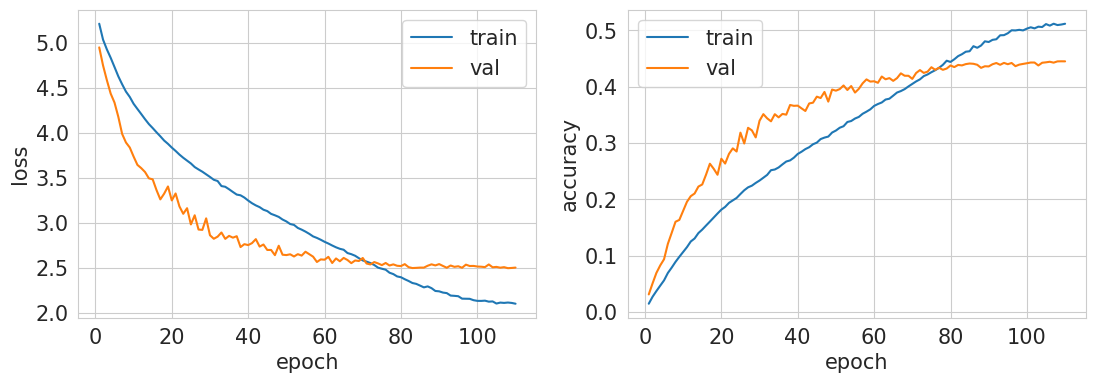

In [14]:
train_losses, val_losses, train_accuracies, val_accuracies = train(
    model, optimizer, scheduler, criterion, train_loader, test_loader, num_epochs
)

In [18]:
print("Val accuracy:", val_accuracies[-1])


Val accuracy: 0.44502857142857144


In [19]:
class PictureTest(Dataset):
    def __init__(self, root_dir, transform=None):
        
    
        self.root_dir = root_dir
        self.transform = transform
        self.image_files = [f for f in os.listdir(root_dir) if os.path.isfile(os.path.join(root_dir, f))]

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        file_name = self.image_files[idx]
        img_path = os.path.join(self.root_dir, file_name)
        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        return image, file_name



In [20]:
model = model

model.eval()
predictions_dict = {}

inference_dataset = PictureTest(root_dir='/kaggle/input/image-dl/bhw1/test', transform=val_transforms)
inference_loader = DataLoader(inference_dataset, batch_size=1, shuffle=False)

with torch.no_grad():
    for images, files in inference_loader:
        images = images.to(device)

        outputs = model(images)

        probabilities = torch.nn.functional.softmax(outputs, dim=1)

        _, predicted_classes = torch.max(probabilities, 1)

        for file_name, pred in zip(files, predicted_classes.cpu().tolist()):
            predictions_dict[file_name] = pred

        
    



In [21]:
import pandas as pd
predictions_df = pd.DataFrame(list(predictions_dict.items()), columns=['Id', 'Category'])
predictions_df.head()


,Id,Category
0,test_04038.jpg,44
1,test_07075.jpg,64
2,test_04342.jpg,155
3,test_00733.jpg,160
4,test_03764.jpg,40


In [22]:
predictions_df.to_csv('/kaggle/working/pred.csv', index=False)